## Importing Libraries

In [1]:
# !pip3 install pyspark
!pip3 install lightfm
!pip3 install apyori

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
from IPython.display import Markdown,display
import gc
import time
from functools import partial
from os import path
from wordcloud import WordCloud
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec, NGram

import random
import numpy
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.evaluation import auc_score
from apyori import apriori
from datetime import datetime
from itertools import combinations

plt.rcParams["figure.figsize"] = (20,10)
warnings.simplefilter('ignore')

/Users/manohar/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [3]:
import sys
print(sys.executable)

/Users/manohar/opt/anaconda3/bin/python


In [4]:
def printmd(string):
    display(Markdown(string))

def get_unique_count(x):
    return len(np.unique(x))

def toReadable(v):
    value=round(v,2) if isinstance(v,float) else v
    if value<1000:
        return str(value)
    elif value<1000000:
        return str(round(value/1000,1))+'K'
    elif value>=1000000:
        return str(round(value/1000000,1))+'M'
    return value

## Reading Data

In [5]:
# Read the data
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

## Feature Selection

In [6]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)
order_products_all = pd.merge(order_products_all, products, on='product_id', how='left')
order_products_all = pd.merge(order_products_all, orders, on='order_id', how='left')
order_products_all = pd.merge(order_products_all, aisles, on='aisle_id', how='left')
order_products_all = pd.merge(order_products_all, departments, on='department_id', how='left')
order_products_all.head()

The order_products_all size is :  (33819106, 4)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned meat seafood,canned goods


In [7]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, orders, on='order_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients,pantry


In [8]:
train_order_products = pd.merge(order_products_train, orders, on='order_id', how='left')
train_order_products = pd.merge(train_order_products, products, on='product_id', how='left')

train_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [9]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
order_products_train = pd.merge(order_products_train, products, on='product_id', how='left')
order_products_train = pd.merge(order_products_train, aisles, on='aisle_id', how='left')
order_products_train = pd.merge(order_products_train, departments, on='department_id', how='left')
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [10]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [11]:
# the product name is a string seperated with whitespace
# we want to replace all whitespace with underscore, so that each product name is actually one word with no space in btw
# And saving it in 'order_products_prior' table, column name 'product_name_with_no_space'

products=order_products_prior['product_name']
product_name_with_no_space=[]
for product in products:
    product=product.replace(" ","_")
    product_name_with_no_space.append(product)
order_products_prior['product_name_with_no_space']=product_name_with_no_space

name_list=[]
for p_name in order_products_prior.groupby('order_id')['product_name_with_no_space']:
    name_list.append(' '.join(p_name[1]))

order_id=order_products_prior.groupby('order_id')['product_name_with_no_space'].agg('count').index
order_products=pd.DataFrame({'order_id':order_id,'products':name_list})

order_products.head()

,order_id,products
0,2,Organic_Egg_Whites Michigan_Organic_Kale Garli...
1,3,Total_2%_with_Strawberry_Lowfat_Greek_Strained...
2,4,Plain_Pre-Sliced_Bagels Honey/Lemon_Cough_Drop...
3,5,"Bag_of_Organic_Bananas Just_Crisp,_Parmesan Fr..."
4,6,Cleanse Dryer_Sheets_Geranium_Scent Clean_Day_...


## Model Building

### Predicting whether a product will be reordered or not

In [12]:
order_all=order_products_all.copy()
orders_new=orders[orders['days_since_prior_order'].notnull()]
order_all.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,112108,train,4,4,10,9.0,yogurt,dairy eggs
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,train,4,4,10,9.0,other creams cheeses,dairy eggs
2,1,10246,3,0,Organic Celery Hearts,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
3,1,49683,4,0,Cucumber Kirby,83,4,112108,train,4,4,10,9.0,fresh vegetables,produce
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,train,4,4,10,9.0,canned meat seafood,canned goods


In [13]:
del order_all['eval_set']
del order_all['add_to_cart_order']

In [14]:
# Average days between orders as a feature by using day_since_prior_order
order_all['average_days_between_orders']=orders_new.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
order_all['average_days_between_orders']=order_all['average_days_between_orders'].replace(np.nan,0)

In [15]:
order_all['average_days_between_orders']=order_all['average_days_between_orders'].replace(0,1)

In [16]:
# number of orders as a feature unsing the orders_new dataset
order_all['nb_orders']=orders_new.groupby('user_id').size().astype(np.int16)
order_all['nb_orders']=order_all['nb_orders'].replace(np.nan,0)

In [17]:
train_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15


In [18]:
# Getting total items using the entire dataset
order_all['total_items']=train_order_products.groupby('user_id').size().astype(np.int16)
order_all['total_items']=order_all['total_items'].replace(np.nan,0)

In [19]:
order_all.head()

,order_id,product_id,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department,average_days_between_orders,nb_orders,total_items
0,1,49302,1,Bulgarian Yogurt,120,16,112108,4,4,10,9.0,yogurt,dairy eggs,1.000000,0.0,0.0
1,1,11109,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,112108,4,4,10,9.0,other creams cheeses,dairy eggs,19.000000,10.0,11.0
2,1,10246,0,Organic Celery Hearts,83,4,112108,4,4,10,9.0,fresh vegetables,produce,16.285715,14.0,31.0
3,1,49683,0,Cucumber Kirby,83,4,112108,4,4,10,9.0,fresh vegetables,produce,12.000000,12.0,0.0
4,1,43633,1,Lightly Smoked Sardines in Olive Oil,95,15,112108,4,4,10,9.0,canned meat seafood,canned goods,17.000000,5.0,0.0


In [20]:
# calculating average basket
order_all['average_basket']=(order_all.total_items/order_all.nb_orders).astype(np.float32)
order_all['average_basket']=order_all['average_basket'].replace(np.nan,0)

In [21]:
# creating a days_since_ratio using days_since_prior_order and average_days_between_orders
order_all['days_since_ratio']=order_all.days_since_prior_order/order_all.average_days_between_orders

In [22]:
order_all=order_all[order_all['days_since_ratio'].notnull()]

In [23]:
order_all.isnull().sum()

order_id                       0
product_id                     0
reordered                      0
product_name                   0
aisle_id                       0
department_id                  0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order         0
aisle                          0
department                     0
average_days_between_orders    0
nb_orders                      0
total_items                    0
average_basket                 0
days_since_ratio               0
dtype: int64

In [24]:
del order_all['user_id']
del order_all['product_name']
del order_all['department']
del order_all['aisle']

In [25]:
order_all.head()

,order_id,product_id,reordered,aisle_id,department_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,average_days_between_orders,nb_orders,total_items,average_basket,days_since_ratio
0,1,49302,1,120,16,4,4,10,9.0,1.000000,0.0,0.0,0.000000,9.000000
1,1,11109,1,108,16,4,4,10,9.0,19.000000,10.0,11.0,1.100000,0.473684
2,1,10246,0,83,4,4,4,10,9.0,16.285715,14.0,31.0,2.214286,0.552632
3,1,49683,0,83,4,4,4,10,9.0,12.000000,12.0,0.0,0.000000,0.750000
4,1,43633,1,95,15,4,4,10,9.0,17.000000,5.0,0.0,0.000000,0.529412


In [26]:
hour={c:i for i,c in enumerate(order_all['order_hour_of_day'].unique())}
aisle={c:i for i,c in enumerate(order_all['aisle_id'].unique())}
dept={c:i for i,c in enumerate(order_all['department_id'].unique())}
product={c:i for i,c in enumerate(order_all['product_id'].unique())}

In [27]:
order_all['aisle_new']=[float(aisle[t]) for t in order_all.aisle_id]
order_all['days_since_prior_order']=order_all['days_since_prior_order'].replace(np.nan,0)

In [28]:
order_all['dept_new'] = [float(dept[t]) for t in order_all.department_id]
order_all['product_new'] = [float(product[t]) for t in order_all.product_id]
order_all['order_hour_of_day_new'] = [float(hour[t]) for t in order_all.order_hour_of_day]
order_all['order_hour_of_day_new'].value_counts()
dow = {c:i for i,c in enumerate(order_all['order_dow'].unique())}
order_all['order_dow_new'] = [float(dow[t]) for t in order_all.order_dow]
dspo = {c:i for i,c in enumerate(order_all['days_since_prior_order'].unique())}
order_all['days_since_prior_order__new'] = [float(dspo[t]) for t in order_all.days_since_prior_order]
order_all['reordered'] = order_all['reordered'].astype('float')

In [29]:
del order_all['aisle_id']
del order_all['department_id']
del order_all['product_id']
del order_all['order_hour_of_day']
del order_all['order_dow']
del order_all['days_since_prior_order']

In [30]:
# variable to be predicted
y=order_all['reordered']

In [31]:
del order_all['reordered']

In [32]:
# final order_all which will be used to run our algorithms
order_all.head()

,order_id,order_number,average_days_between_orders,nb_orders,total_items,average_basket,days_since_ratio,aisle_new,dept_new,product_new,order_hour_of_day_new,order_dow_new,days_since_prior_order__new
0,1,4,1.000000,0.0,0.0,0.000000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4,19.000000,10.0,11.0,1.100000,0.473684,1.0,0.0,1.0,0.0,0.0,0.0
2,1,4,16.285715,14.0,31.0,2.214286,0.552632,2.0,1.0,2.0,0.0,0.0,0.0
3,1,4,12.000000,12.0,0.0,0.000000,0.750000,2.0,1.0,3.0,0.0,0.0,0.0
4,1,4,17.000000,5.0,0.0,0.000000,0.529412,3.0,2.0,4.0,0.0,0.0,0.0


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,accuracy_score

In [34]:
X_train,X_test,y_train,y_test=train_test_split(order_all,y,test_size=0.33,random_state=1234)
y_train=y_train.ravel()
y_test=y_test.ravel()

### Logistic Regression

In [35]:
# Logistic regression
clf=LogisticRegression().fit(X_train,y_train)

In [36]:
#predictions
pred=clf.predict(X_test)

In [37]:
print(accuracy_score(y_test,pred))

0.6555195773218937


### Gradient Boosting Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
clfg= GradientBoostingClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000)

In [39]:
#fitting
clfg.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=11, max_features='log2',
                           min_samples_split=1000, n_estimators=24)

In [40]:
#predictions
predg = clfg.predict(X_test)

In [41]:
#accuracy score for Gradient Boosting Classifier
accuracy_score(predg, y_test)

0.7071223059564508

### Random forest Classifier

In [42]:
rf=RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [43]:
#fitting
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, max_features='log2',
                       min_samples_split=1000, n_estimators=24, oob_score=True)

In [44]:
#predictions
rf_pred=rf.predict(X_test)

In [45]:
#accuracy score for the random forest model
accuracy_score(rf_pred, y_test)

0.7022437160265608

order_number                   0.556952
dept_new                       0.178566
product_new                    0.105989
aisle_new                      0.085826
days_since_prior_order__new    0.036269
days_since_ratio               0.032386
order_dow_new                  0.001205
order_hour_of_day_new          0.001197
order_id                       0.000997
average_days_between_orders    0.000253
nb_orders                      0.000165
average_basket                 0.000112
total_items                    0.000083
dtype: float64

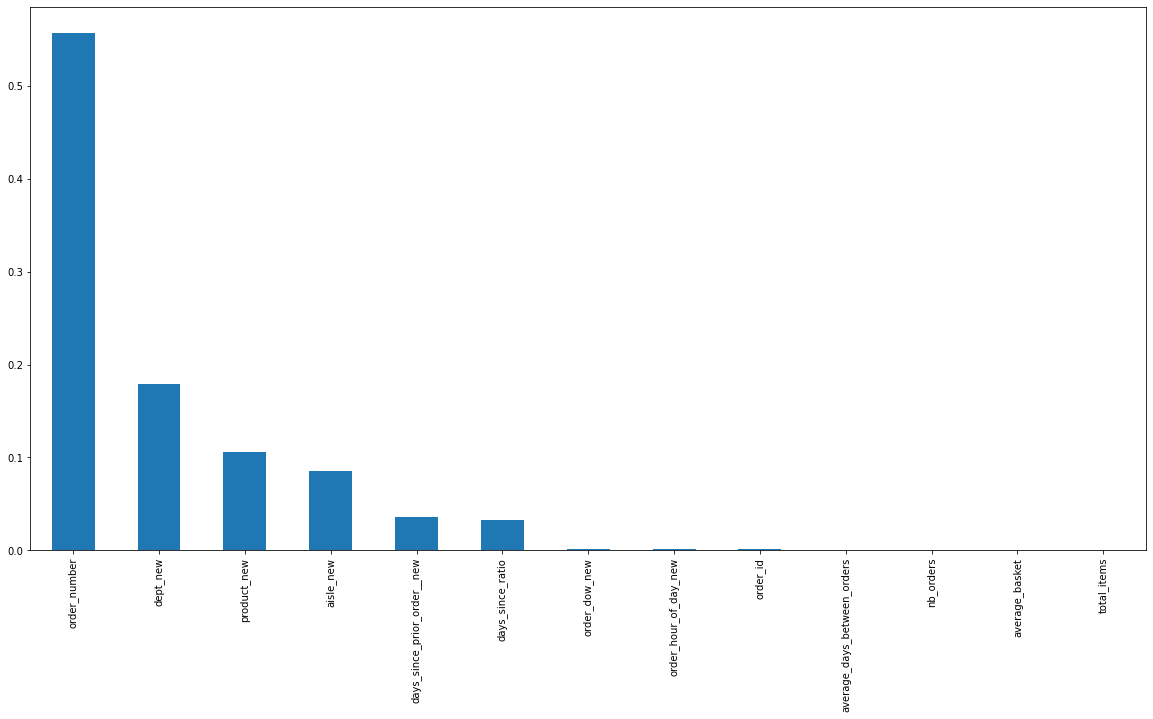

In [46]:
feature_imp_reordered=pd.Series(clfg.feature_importances_,index=order_all.columns)
feature_imp_reordered.sort_values(ascending=False).plot(kind='bar')
feature_imp_reordered.sort_values(ascending=False)

- The most important features to predict whether a product will be reordered or not are `order_numer`, `department`, `porduct`, `aisle`, `days_since_ratio`, `days_since_prior_order`.

### Predicting whether a product from the department will be reordered or not

In [47]:
order_all_new=order_products_all.copy()

In [48]:
# creating new features such as orders,
# reorders and reorder_rate for predicting the department variable

order_all_new['orders'] = order_all_new.groupby(order_all_new.product_id).size().astype(np.int32) 
order_all_new['orders'] = order_all_new['orders'].replace(np.nan,0)
order_all_new['reorders'] = order_all_new['reordered'].groupby(order_all_new.product_id).sum().astype(np.float32)
order_all_new['reorders'] = order_all_new['reorders'].replace(np.nan,0)
order_all_new['reorder_rate'] = (order_all_new.reorders / order_all_new.orders).astype(np.float32)
order_all_new['reorder_rate'] = order_all_new['reorder_rate'].replace(np.nan,0)

In [49]:
order_all_new['average_days_between_orders'] = orders_new.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
order_all_new['average_days_between_orders'] = order_all_new['average_days_between_orders'].replace(np.nan, 0)

In [50]:
order_all_new['average_days_between_orders'] = order_all_new['average_days_between_orders'].replace(0, 1)

In [51]:
order_all_new['nb_orders'] = orders_new.groupby('user_id').size().astype(np.int16)
order_all_new['nb_orders'] = order_all_new['nb_orders'].replace(np.nan, 0)

In [52]:
#Getting the total items using the entire dataset 
order_all_new['total_items'] = train_order_products.groupby('user_id').size().astype(np.int16)
order_all_new['total_items'] = order_all_new['total_items'].replace(np.nan, 0)

In [53]:
order_all_new['average_basket'] = (order_all_new.total_items /order_all_new.nb_orders).astype(np.float32)

In [54]:
order_all_new['average_basket'] = order_all_new['average_basket'].replace(np.nan, 0)

In [55]:
order_all_new['days_since_ratio'] = order_all_new.days_since_prior_order / order_all_new.average_days_between_orders

In [56]:
order_all_new['order_hour_of_day_new'] = [float(hour[t]) for t in order_all_new.order_hour_of_day]

In [57]:
order_all_new['reordered'] = order_all_new['reordered'].astype('float')

In [58]:
order_all_new['order_dow_new'] = [float(dow[t]) for t in order_all_new.order_dow]

In [59]:
order_all_new = order_all_new[order_all_new['days_since_prior_order'].notnull()]

In [60]:
order_all_new['days_since_prior_order__new'] = [float(dspo[t]) for t in order_all_new.days_since_prior_order]

In [61]:
order_all_new['dept_new'] = [float(dept[t]) for t in order_all_new.department_id]

In [62]:
order_all_new['product_new'] = [float(product[t]) for t in order_all_new.product_id]

In [63]:
del order_all_new['days_since_prior_order']
del order_all_new['order_dow']
del order_all_new['order_hour_of_day']
del order_all_new['department_id']
del order_all_new['aisle_id']
del order_all_new['product_id']
del order_all_new['add_to_cart_order']
del order_all_new['eval_set']
del order_all_new['department']
del order_all_new['product_name']
del order_all_new['product_new']

In [64]:
order_all_new.head()

,order_id,reordered,user_id,order_number,aisle,orders,reorders,reorder_rate,average_days_between_orders,nb_orders,total_items,average_basket,days_since_ratio,order_hour_of_day_new,order_dow_new,days_since_prior_order__new,dept_new
0,1,1.0,112108,4,yogurt,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,9.000000,0.0,0.0,0.0,0.0
1,1,1.0,112108,4,other creams cheeses,1928.0,1185.0,0.614627,19.000000,10.0,11.0,1.100000,0.473684,0.0,0.0,0.0,0.0
2,1,0.0,112108,4,fresh vegetables,94.0,13.0,0.138298,16.285715,14.0,31.0,2.214286,0.552632,0.0,0.0,0.0,1.0
3,1,0.0,112108,4,fresh vegetables,283.0,209.0,0.738516,12.000000,12.0,0.0,0.000000,0.750000,0.0,0.0,0.0,1.0
4,1,1.0,112108,4,canned meat seafood,351.0,161.0,0.458689,17.000000,5.0,0.0,0.000000,0.529412,0.0,0.0,0.0,2.0


In [65]:
y_new=order_all_new['dept_new']

In [66]:
del order_all_new['dept_new']

In [67]:
del order_all_new['aisle']

In [68]:
X_train_new,X_test_new,y_train_new,y_test_new=train_test_split(order_all_new,y_new,test_size=0.33,random_state=123)

In [69]:
# Random Forest Classifier
gb_dep=GradientBoostingClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000)

In [ ]:
gb_dep.fit(X_train_new,y_train_new)

In [ ]:
gb_dep_pred=gb_dep.predict_proba(X_test_new)

In [ ]:
featIMPdept=pd.series(gb_dep.feature_importance,index=order_all_new.columns)
featIMPdept.sort_values(ascending=False)